# Fashion MNIST

### Imports and loading the data

In [34]:
import torch
import torchvision

from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms

# The output of torchvision datasets are PILImage images of range [0, 1]. 
train_transform = transforms.Compose( [transforms.RandomRotation(30),
                               # transforms.RandomResizedCrop(28),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor()] )

test_transform = transforms.ToTensor()


# choose the training and test datasets
train_data = FashionMNIST(root='./data', train=True,
                                   download=True, transform=train_transform)

test_data = FashionMNIST(root='./data', train=False,
                                  download=True, transform=test_transform)


# Print out some stats about the training and test data
print('Train data, number of images: ', len(train_data))
print('Test data, number of images: ', len(test_data))

Train data, number of images:  60000
Test data, number of images:  10000


In [35]:
batch_size = 20

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# specify the image classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### Visualize some training data


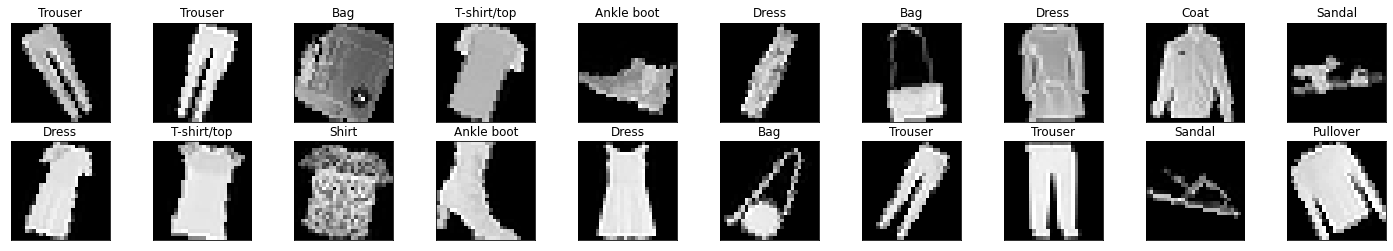

In [36]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

## Building the Model

In [37]:
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 10, 3) # After conv1 shape will be: (10, 26, 26),
        
        self.pool = nn.MaxPool2d(2, 2)      # after pooling shape is :(10, 13, 13)
        self.batch_norm1 = nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(10, 20, 3)  # After conv2 shape will be :(20, 11, 11), after pooling the shape will be: (20, 5, 5)
        self.batch_norm2 = nn.BatchNorm2d(20)
        self.fc1 = nn.Linear(20*5*5, 50)
        
        self.fc1_drop = nn.Dropout(p=0.4)
        
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
      x = self.pool(F.relu(self.batch_norm1(self.conv1(x))))
      x = self.pool(F.relu(self.batch_norm2(self.conv2(x))))
      
      x = x.view(x.size(0), -1)    #Flattening
      
      # two linear layers with dropout in between
      x = F.relu(self.fc1(x))
      x = self.fc1_drop(x)
      x = self.fc2(x)
  
      return x                 # final output

net = Net()


In [38]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
summary(net, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
       BatchNorm2d-2           [-1, 10, 26, 26]              20
         MaxPool2d-3           [-1, 10, 13, 13]               0
            Conv2d-4           [-1, 20, 11, 11]           1,820
       BatchNorm2d-5           [-1, 20, 11, 11]              40
         MaxPool2d-6             [-1, 20, 5, 5]               0
            Linear-7                   [-1, 50]          25,050
           Dropout-8                   [-1, 50]               0
            Linear-9                   [-1, 10]             510
Total params: 27,540
Trainable params: 27,540
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.16
Params size (MB): 0.11
Estimated Total Size (MB): 0.27
---------------------------------------------

## Training

In [44]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()  
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 3)

## Initial Predictions
- As the model is not trained the accuracy should be around 10% i.e random guessing

In [40]:
correct = 0
total = 0
net.to('cpu')
for images, labels in test_loader:
    net.to('cpu')
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
accuracy = 100.0 * correct.item() / total
print('Accuracy before training: ', accuracy)

Accuracy before training:  8.23


In [41]:
net.to(device)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batch_norm1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=500, out_features=50, bias=True)
  (fc1_drop): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

### Train the Network

* Inside the epoch loop, we loop over the training dataset in batches; recording the loss every 1000 batches.


In [42]:
def train(n_epochs):
    loss_over_time = [] 
    
    for epoch in range(n_epochs): 
        running_loss = 0.0
        for batch_i, data in enumerate(train_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            #scheduler.step()
            optimizer.step()

            running_loss += loss.item()
            if batch_i % 1000 == 999:         # print every 1000 batches
                avg_loss = running_loss/1000
                # record and print the avg loss over the 1000 batches
                loss_over_time.append(avg_loss)
                print('Epoch: {}, Batch: {}, Avg. Loss: {}, Accuracy on test: {} '.format(epoch + 1, batch_i+1, avg_loss, acc_on_test()))
                
                running_loss = 0.0
    scheduler.step()            
    print('Finished Training!')
    return loss_over_time

In [43]:
#for finding test accuracy during training
def acc_on_test():
  test_loss = torch.zeros(1)
  class_correct = list(0. for i in range(10))
  class_total = list(0. for i in range(10))
  # set to evaluation mode
  net.to(device)
  net.eval()
  for batch_i, data in enumerate(test_loader):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    test_loss = test_loss + ((torch.ones(1) / (batch_i + 1)) * (loss.data - test_loss))
    _, predicted = torch.max(outputs.data, 1)
    correct = np.squeeze(predicted.eq(labels.data.view_as(predicted)))
    for i in range(batch_size):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1 
    return (100. * np.sum(class_correct) / np.sum(class_total))  

In [45]:
n_epochs = 15 
training_loss = train(n_epochs)

Epoch: 1, Batch: 1000, Avg. Loss: 1.040280680000782, Accuracy on test: 65.0 
Epoch: 1, Batch: 2000, Avg. Loss: 0.6063598532825708, Accuracy on test: 65.0 
Epoch: 1, Batch: 3000, Avg. Loss: 0.5442453266978264, Accuracy on test: 75.0 
Epoch: 2, Batch: 1000, Avg. Loss: 0.5098008151501418, Accuracy on test: 90.0 
Epoch: 2, Batch: 2000, Avg. Loss: 0.4874756520576775, Accuracy on test: 90.0 
Epoch: 2, Batch: 3000, Avg. Loss: 0.4689758581891656, Accuracy on test: 90.0 
Epoch: 3, Batch: 1000, Avg. Loss: 0.45439158826321363, Accuracy on test: 75.0 
Epoch: 3, Batch: 2000, Avg. Loss: 0.4374406580850482, Accuracy on test: 80.0 
Epoch: 3, Batch: 3000, Avg. Loss: 0.4492163415849209, Accuracy on test: 70.0 
Epoch: 4, Batch: 1000, Avg. Loss: 0.4217724345959723, Accuracy on test: 75.0 
Epoch: 4, Batch: 2000, Avg. Loss: 0.42048282019793987, Accuracy on test: 85.0 
Epoch: 4, Batch: 3000, Avg. Loss: 0.4123543913438916, Accuracy on test: 90.0 
Epoch: 5, Batch: 1000, Avg. Loss: 0.4141858224719763, Accuracy 

## Visualizing the loss


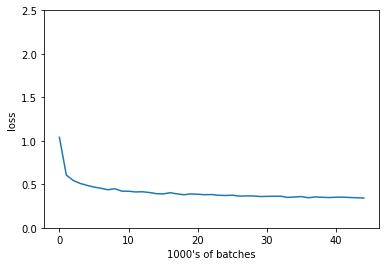

In [46]:
# visualize the loss as the network trained
plt.plot(training_loss)
plt.xlabel('1000\'s of batches')
plt.ylabel('loss')
plt.ylim(0, 2.5) # consistent scale
plt.show()

### Test the Trained Network

- Final Testing across classes

In [47]:
net.to("cpu")
# initialize tensor and lists to monitor test loss and accuracy
test_loss = torch.zeros(1)
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
# set the module to evaluation mode
net.eval()

for batch_i, data in enumerate(test_loader):
    
    # get the input images and their corresponding labels
    inputs, labels = data
    
    # forward pass to get outputs
    outputs = net(inputs)

    # calculate the loss
    loss = criterion(outputs, labels)
            
    # update average test loss 
    test_loss = test_loss + ((torch.ones(1) / (batch_i + 1)) * (loss.data - test_loss))
    
    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)
    
    # compare predictions to true label
    # this creates a `correct` Tensor that holds the number of correctly classified images in a batch
    correct = np.squeeze(predicted.eq(labels.data.view_as(predicted)))
    
    # calculate test accuracy for *each* object class
    # we get the scalar value of correct items for a class, by calling `correct[i].item()`
    for i in range(batch_size):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

print('Test Loss: {:.6f}\n'.format(test_loss.numpy()[0]))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

        
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.371714

Test Accuracy of T-shirt/top: 81% (816/1000)
Test Accuracy of Trouser: 95% (958/1000)
Test Accuracy of Pullover: 71% (713/1000)
Test Accuracy of Dress: 86% (866/1000)
Test Accuracy of  Coat: 85% (855/1000)
Test Accuracy of Sandal: 89% (890/1000)
Test Accuracy of Shirt: 65% (658/1000)
Test Accuracy of Sneaker: 97% (974/1000)
Test Accuracy of   Bag: 97% (971/1000)
Test Accuracy of Ankle boot: 94% (947/1000)

Test Accuracy (Overall): 86% (8648/10000)


### Visualize sample test results


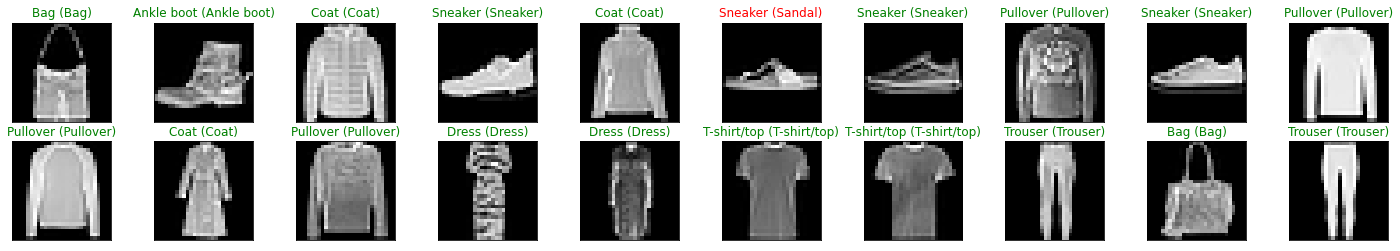

In [48]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
preds = np.squeeze(net(images).data.max(1, keepdim=True)[1].numpy())
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx] else "red"))